<h1> Library 

In [1]:
# Standard library imports
import os 
import glob
import numpy as np
import itertools

# Third party imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as LGB
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso,ElasticNet,Ridge
from sklearn.svm import SVR

from tqdm import tqdm
import plotly 
import plotly.express as px
import plotly.graph_objects as go 
from plotly.subplots import make_subplots
import matplotlib
from matplotlib import font_manager, rc
import shap

# Dacon plotly 그림 업로드 
pd.options.plotting.backend = 'plotly'
## plotly.io를 import 한 후 renderers 기본값을 꼭 "notebook_connected" 로 설정해주시기 바랍니다.
import plotly.io as pio
pio.renderers.default = "notebook_connected"

#options 
pd.set_option('display.max_columns', None)
rc('font', family='AppleGothic')
matplotlib.rcParams['axes.unicode_minus'] = False


<H1> Data Loading 

<h1> Data Prep 

In [2]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_gender = pd.read_csv("data/age_gender_info.csv")
df_sub = pd.read_csv("data/sample_submission.csv")

In [3]:
display("Train", df_train.head(10))
display("Test", df_test.head(10))

'Train'

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
5,C2483,900,아파트,경상북도,국민임대,51.95,89,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
6,C2483,900,아파트,경상북도,국민임대,51.95,135,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
7,C2483,900,아파트,경상북도,국민임대,59.88,86,38.0,A,30357000,214270,0.0,3.0,1425.0,1015.0
8,C2515,545,아파트,경상남도,국민임대,33.48,276,17.0,A,9216000,82940,0.0,3.0,624.0,205.0
9,C2515,545,아파트,경상남도,국민임대,39.60,60,17.0,A,12672000,107130,0.0,3.0,624.0,205.0


'Test'

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000,189840,0.0,2.0,683.0
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000,249930,0.0,2.0,683.0
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000,249930,0.0,2.0,683.0
3,C1072,754,아파트,경기도,국민임대,46.90,120,14.0,H,36048000,249930,0.0,2.0,683.0
4,C1072,754,아파트,경기도,국민임대,51.46,60,14.0,H,43497000,296780,0.0,2.0,683.0
5,C1072,754,아파트,경기도,국민임대,51.71,51,14.0,H,43497000,296780,0.0,2.0,683.0
6,C1072,754,아파트,경기도,국민임대,51.96,198,14.0,H,43497000,296780,0.0,2.0,683.0
7,C1072,754,아파트,경기도,국민임대,51.96,67,14.0,H,43497000,296780,0.0,2.0,683.0
8,C1128,1354,아파트,경기도,국민임대,39.79,368,9.0,H,22830000,189840,0.0,3.0,1216.0
9,C1128,1354,아파트,경기도,국민임대,39.79,30,9.0,H,22830000,189840,0.0,3.0,1216.0


단지 코드 중첩, 임대건물 구분, 지역, 공급유형, 전용면적 등 정보 병합 필요 

In [4]:
display(df_train.describe())
display(df_test.describe())

,총세대수,전용면적,전용면적별세대수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
count,2952.000000,2952.000000,2952.000000,2952.000000,2741.000000,2948.000000,2952.000000,2952.000000
mean,886.661247,44.757215,102.747967,12.921070,0.176578,3.695726,601.668360,559.768293
std,513.540168,31.874280,132.640159,10.778831,0.427408,2.644665,396.407072,433.375027
min,26.000000,12.620000,1.000000,0.000000,0.000000,0.000000,13.000000,13.000000
25%,513.500000,32.100000,14.000000,4.000000,0.000000,2.000000,279.250000,220.000000
50%,779.000000,39.930000,60.000000,11.000000,0.000000,3.000000,517.000000,487.000000
75%,1106.000000,51.562500,144.000000,20.000000,0.000000,4.000000,823.000000,770.000000
max,2568.000000,583.400000,1865.000000,55.000000,3.000000,20.000000,1798.000000,2550.000000


,총세대수,전용면적,전용면적별세대수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
count,1022.000000,1022.000000,1022.000000,1022.000000,980.000000,1022.000000,1022.000000
mean,862.080235,43.706311,100.414873,15.544031,0.136735,4.626223,548.771037
std,536.340894,35.890759,125.997855,11.070140,0.435500,5.414568,342.636703
min,75.000000,9.960000,1.000000,0.000000,0.000000,1.000000,29.000000
25%,488.000000,33.135000,14.000000,6.000000,0.000000,2.000000,286.000000
50%,745.000000,39.720000,60.000000,15.000000,0.000000,3.000000,458.000000
75%,1161.000000,47.400000,140.000000,23.000000,0.000000,5.000000,711.000000
max,2572.000000,583.400000,1341.000000,45.000000,2.000000,50.000000,1696.000000


<h2> Step 1

In [5]:
train_tmp = df_train.iloc[:,0:-1]
train_tmp['type'] = 'train'
test_tmp = df_test
test_tmp['type'] = 'test'

df_all = pd.concat([train_tmp, test_tmp], axis=0)

names = ["자격유형", "공급유형", "임대건물구분", "지역"]
fig = make_subplots(rows=2, cols=2, subplot_titles=("자격유형", "공급유형", "임대건물구분", "지역"))
postion = {'0' : [1,1], '1' : [1,2], '2' : [2,1], '3' : [2,2]}

for order, name in enumerate(names):
    row, col = postion[str(order)][0], postion[str(order)][1]
    fig.add_trace(go.Bar(name='Train', x=df_all[name], y=df_all[name]), row=row, col=col)
    fig.add_trace(go.Bar(name='Test', x=df_all[name], y=df_all[name]), row=row, col=col)

fig.update_layout(barmode='stack', 
    autosize=False,
    width=800,
    height=600,)
# fig.show()

del train_tmp,test_tmp,df_all

<h2> Train vs Test 명목 변수 차집합 

In [6]:
columns = ['임대건물구분', '지역', '공급유형', '자격유형']
for col in columns:
    complement = list(set(df_train[col].unique()) - set(df_test[col].unique()))
    print(f"Train 데이터 기준 차집합 {col} : {complement}")
    

Train 데이터 기준 차집합 임대건물구분 : []
Train 데이터 기준 차집합 지역 : ['서울특별시']
Train 데이터 기준 차집합 공급유형 : ['공공분양', '공공임대(5년)', '장기전세']
Train 데이터 기준 차집합 자격유형 : ['F', 'B', 'O']


Train 데이터에만 있는 값들 제거 필요할까? 
그럼 얼마나 포함하고 있을까? <br>
100개 정도 포함하고 있네 어떻게 처리하지?

버릴까? 다른 이름으로 병합할까?



In [7]:
options = True 

if options:
    # 방안 1  값 통일 
    df_train.loc[df_train.지역.isin(['서울특별시']), '지역'] = '이외'
    df_train.loc[df_train.공급유형.isin(['공공임대(5년)', '장기전세', '공공분양']), '공급유형'] = '이외'
    df_train.loc[df_train.자격유형.isin(['O', 'B', 'F']), '공급유형'] = '이외'
else:
    #방안 2 Drop

    df_train = df_train.loc[df_train.지역 != '서울특별시']

    mask = df_train.공급유형 != '공공분양'
    mask &= df_train.공급유형 != '장기전세'
    mask &= df_train.공급유형 != '공공임대(5년)'
    df_train = df_train.loc[mask]

    mask = df_train.자격유형 != 'F'
    mask &= df_train.자격유형 != 'B'
    mask &= df_train.자격유형 != 'O'
    df_train = df_train.loc[mask]


<h3> for Train data

In [8]:
print (f'train data \n{df_train.isnull().sum()}')

train data 
단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           569
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    211
도보 10분거리 내 버스정류장 수                4
단지내주차면수                           0
등록차량수                             0
dtype: int64


공란이 제법 있군

In [9]:
## 공란 처리 및 기타 작업 
## 문자열 처리 
df_train.rename(columns={"도보 10분거리 내 지하철역 수(환승노선 수 반영)" : "지하철", "도보 10분거리 내 버스정류장 수" : "버스"}, inplace=True)
df_train[['임대보증금','임대료']] = df_train[['임대보증금', '임대료']].fillna("0").replace("-", "0").astype(int)

## 지하철 버스 공란 변경하기 
df_train['지하철'].fillna(0,inplace=True)
df_train['버스'].fillna(0,inplace=True)

##면적은 게속 변경 하면서 확인할것 
df_train['전용면적'] = df_train['전용면적'] //10*10
df_train['전용면적'] = np.where(df_train['전용면적'] > 100, 100, df_train['전용면적'])
df_train['전용면적'] = np.where(df_train['전용면적'] < 15, 15, df_train['전용면적'])

if df_train.isnull().sum().sum() != 0:
    print (df_train.isnull().sum())
else:
    print("공란 없어요")

## 카데코리화 
df_train.loc[:,'임대용총전용면적'] = df_train.loc[:,'전용면적'] * df_train.loc[:,'전용면적별세대수']
df_train.loc[:,"임대건물구분"] = df_train.loc[:,"임대건물구분"].astype('category').cat.codes
df_train.loc[:,'지역'] = df_train.loc[:,'지역'].astype('category').cat.codes
df_train.loc[:,'공급유형'] = df_train.loc[:,'공급유형'].astype('category').cat.codes
df_train.loc[:,'자격유형'] = df_train.loc[:,'자격유형'].astype('category').cat.codes
df_train['key'] = df_train['임대건물구분'].astype(str).str.cat(df_train['공급유형'].astype(str), sep='-').str.cat(df_train['자격유형'].astype(str), sep='-')


공란 없어요


<h3> for df_test

In [10]:
print (f'test data \n{df_test.isnull().sum()}')

test data 
단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              2
임대보증금                           180
임대료                             180
도보 10분거리 내 지하철역 수(환승노선 수 반영)     42
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
type                              0
dtype: int64


역시 공란이 좀 있군, 자격 유형에 공란있네 

In [11]:
df_test[df_test.자격유형.isnull()]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,type
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0.0,2.0,840.0,test
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0.0,2.0,173.0,test


In [12]:
df_test[(df_test.단지코드=='C2411') | (df_test.단지코드=='C2253')].head(10)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,type
193,C2411,962,아파트,경상남도,국민임대,39.43,56,25.0,A,11992000,100720,0.0,2.0,840.0,test
194,C2411,962,아파트,경상남도,국민임대,39.72,336,25.0,A,11992000,100720,0.0,2.0,840.0,test
195,C2411,962,아파트,경상남도,국민임대,39.82,179,25.0,A,11992000,100720,0.0,2.0,840.0,test
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0.0,2.0,840.0,test
197,C2411,962,아파트,경상남도,국민임대,51.93,150,25.0,A,21586000,171480,0.0,2.0,840.0,test
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0.0,2.0,173.0,test
259,C2253,1161,아파트,강원도,영구임대,31.32,239,0.0,C,3731000,83020,0.0,2.0,173.0,test
260,C2253,1161,아파트,강원도,영구임대,31.32,149,0.0,C,3731000,83020,0.0,2.0,173.0,test
261,C2253,1161,상가,강원도,임대상가,13.77,1,0.0,D,NaN,NaN,0.0,2.0,173.0,test
262,C2253,1161,상가,강원도,임대상가,22.89,1,0.0,D,NaN,NaN,0.0,2.0,173.0,test


임대료 있고, 임대보증금 있는데 공란이네, c2411은 A로, c2253은 C로 넣으면 되겠네 

In [13]:
## 빠진 자격 유형 
df_test.loc[(df_test.자격유형.isnull()) & (df_test.단지코드 == "C2411"), '자격유형'] = 'A'
df_test.loc[(df_test.자격유형.isnull()) & (df_test.단지코드 == "C2253"), '자격유형'] = 'C'

## 문자열 처리 
df_test.rename(columns={"도보 10분거리 내 지하철역 수(환승노선 수 반영)" : "지하철", "도보 10분거리 내 버스정류장 수" : "버스"}, inplace=True)
df_test[['임대보증금','임대료']] = df_test[['임대보증금', '임대료']].fillna("0").replace("-", "0").astype(int)

## 지하철 버스 공란 변경하기 
df_test['지하철'].fillna(0,inplace=True)
df_test['버스'].fillna(0,inplace=True)

##면적은 게속 변경 하면서 확인할것 
df_test['전용면적'] = df_test['전용면적'] //10*10
df_test['전용면적'] = np.where(df_test['전용면적'] > 100, 100, df_test['전용면적'])
df_test['전용면적'] = np.where(df_test['전용면적'] < 15, 15, df_test['전용면적'])


if df_test.isnull().sum().sum() != 0:
    print(df_test.isnull().sum())
else:
    print("공란 없어요")

df_test.loc[:,'임대용총전용면적'] = df_test.loc[:,'전용면적'] * df_test.loc[:,'전용면적별세대수']
df_test.loc[:,"임대건물구분"] = df_test.loc[:,"임대건물구분"].astype('category').cat.codes
df_test.loc[:,'지역'] = df_test.loc[:,'지역'].astype('category').cat.codes
df_test.loc[:,'공급유형'] = df_test.loc[:,'공급유형'].astype('category').cat.codes
df_test.loc[:,'자격유형'] = df_test.loc[:,'자격유형'].astype('category').cat.codes
df_test['key'] = df_test['임대건물구분'].astype(str).str.cat(df_test['공급유형'].astype(str), sep='-').str.cat(df_test['자격유형'].astype(str), sep='-')

# df_test.loc[df_test.자격유형.isnull()]

공란 없어요


<h2>성별 정보 

In [14]:
# 성별 구성 지역 카테고리 
df_gender.loc[:,'지역'] = df_gender.loc[:,'지역'].astype('category').cat.codes



<h2> 명목변수 확인

어떻게 병합할 것인가? 명목 변수 중복은 없니? 


In [15]:
codes = df_train.단지코드.unique()

diff_key =[]

for code in codes:
    tmp = df_train.loc[df_train.단지코드 == code]
    if len(tmp.key.unique()) !=1:
        diff_key.append(code)

df_by_key = df_train.loc[df_train['단지코드'].isin(diff_key),:]
df_by_key.head(14)



,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수,임대용총전용면적,key
86,C1925,601,1,0,4,20.0,298,9.0,2,8052000,130850,0.0,4.0,117.0,75.0,5960.0,1-4-2
87,C1925,601,1,0,4,30.0,298,9.0,2,9174000,144460,0.0,4.0,117.0,75.0,8940.0,1-4-2
88,C1925,601,0,0,6,30.0,1,9.0,3,0,0,0.0,4.0,117.0,75.0,30.0,0-6-3
89,C1925,601,0,0,6,30.0,1,9.0,3,0,0,0.0,4.0,117.0,75.0,30.0,0-6-3
90,C1925,601,0,0,6,30.0,1,9.0,3,0,0,0.0,4.0,117.0,75.0,30.0,0-6-3
91,C1925,601,0,0,6,70.0,1,9.0,3,0,0,0.0,4.0,117.0,75.0,70.0,0-6-3
98,C1874,619,1,14,4,20.0,294,2.0,2,3141000,69900,0.0,2.0,97.0,62.0,5880.0,1-4-2
99,C1874,619,1,14,4,20.0,149,2.0,2,3141000,69900,0.0,2.0,97.0,62.0,2980.0,1-4-2
100,C1874,619,1,14,4,30.0,149,2.0,2,3731000,83020,0.0,2.0,97.0,62.0,4470.0,1-4-2
101,C1874,619,0,14,6,15.0,1,2.0,3,0,0,0.0,2.0,97.0,62.0,15.0,0-6-3


단지코드 601 88~90 모든 행열의 값이 동일 단순 실수? 
87과 비교하면 공급유형과 자격유형이 다르네, 공급유형과 자격유형에 따라 구분하기 위함인듯 

"임대건물구분", "공금유형", "자격유형"으로 Key를 구성하였을 때 같은 단지코드라도 다른 key값이 발생됨 

key 값마다 예상 등록 차량수를 예측하면 좋겠지만 훈련 데이터의 동록 차량수는 총합만 기록되어 있음 

"임대건물구분", "공금유형", "자격유형"은 제외해야 하나?

In [16]:
codes = df_test.단지코드.unique()

diff_key =[]

for code in codes:
    tmp = df_test.loc[df_test.단지코드 == code]
    if len(tmp.key.unique()) !=1:
        diff_key.append(code)

df_by_key = df_test.loc[df_test['단지코드'].isin(diff_key),:]
df_by_key.head(14)

## test에도 단지 코드별 다른 key값 발생 

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,type,임대용총전용면적,key
0,C1072,754,1,1,3,30.0,116,14.0,5,22830000,189840,0.0,2.0,683.0,test,3480.0,1-3-5
1,C1072,754,1,1,3,40.0,30,14.0,0,36048000,249930,0.0,2.0,683.0,test,1200.0,1-3-0
2,C1072,754,1,1,3,40.0,112,14.0,5,36048000,249930,0.0,2.0,683.0,test,4480.0,1-3-5
3,C1072,754,1,1,3,40.0,120,14.0,5,36048000,249930,0.0,2.0,683.0,test,4800.0,1-3-5
4,C1072,754,1,1,3,50.0,60,14.0,5,43497000,296780,0.0,2.0,683.0,test,3000.0,1-3-5
5,C1072,754,1,1,3,50.0,51,14.0,5,43497000,296780,0.0,2.0,683.0,test,2550.0,1-3-5
6,C1072,754,1,1,3,50.0,198,14.0,5,43497000,296780,0.0,2.0,683.0,test,9900.0,1-3-5
7,C1072,754,1,1,3,50.0,67,14.0,5,43497000,296780,0.0,2.0,683.0,test,3350.0,1-3-5
8,C1128,1354,1,1,3,30.0,368,9.0,5,22830000,189840,0.0,3.0,1216.0,test,11040.0,1-3-5
9,C1128,1354,1,1,3,30.0,30,9.0,5,22830000,189840,0.0,3.0,1216.0,test,900.0,1-3-5


우선은 신경쓰지 말자. 나중에 고민

<h1> Test Data, Test Data <br> 
<h3> 주차 면수와 나머지 변수의 상관관계

In [17]:
## 그림을 위해 train , test 하나의 df로 

train_tmp = df_train.iloc[:,0:-1]
train_tmp['type'] = 'train'
test_tmp = df_test
test_tmp['type'] = 'test'

df_all = pd.concat([train_tmp, test_tmp], axis=0)

df_all = df_all.drop_duplicates(['단지코드'], keep='first').reset_index(drop=True)

In [18]:
df_all

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수,임대용총전용면적,type,key
0,C2483,900,1,3,3,30.0,134,38.0,0,15667000,103680,0.0,3.0,1425.0,1015.0,4020.0,train,NaN
1,C2515,545,1,2,3,30.0,276,17.0,0,9216000,82940,0.0,3.0,624.0,205.0,8280.0,train,NaN
2,C1407,1216,1,6,3,30.0,288,13.0,0,15620000,127350,1.0,1.0,1285.0,1064.0,8640.0,train,NaN
3,C1945,755,1,1,5,30.0,120,6.0,1,15607000,130070,1.0,3.0,734.0,730.0,3600.0,train,NaN
4,C1470,696,1,12,3,30.0,228,14.0,0,12015000,102130,0.0,2.0,645.0,553.0,6840.0,train,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,C2456,349,1,12,3,20.0,24,17.0,5,6992000,117000,0.0,4.0,270.0,NaN,480.0,test,1-3-5
569,C1266,596,1,14,3,20.0,164,35.0,5,8084000,149910,0.0,1.0,593.0,NaN,3280.0,test,1-3-5
570,C2152,120,1,0,4,20.0,66,9.0,1,0,0,0.0,1.0,40.0,NaN,1320.0,test,1-4-1
571,C1267,675,1,2,3,20.0,28,38.0,5,6882000,104370,0.0,1.0,467.0,NaN,560.0,test,1-3-5


In [19]:
df = df_all[['등록차량수', '총세대수',	'임대건물구분',	'지역',	'공급유형',	'전용면적',	'전용면적별세대수',	'공가수',	'자격유형',	'임대보증금',	'임대료',	'지하철',	'버스',	'단지내주차면수',	'임대용총전용면적', 'type']]
fig = px.scatter_matrix(df, color = 'type' )
fig.update_layout(dragmode='select',
                  width=1000,
                  height=1000,
                  hovermode='closest')
fig.update_traces(diagonal_visible=False)
fig.show()

대충 저렇게 그려지는데 Train과 Test 분포가 조금 다르네

<h3> 하나씩 살펴 보면 

In [20]:

fig = px.scatter(df_all, x="총세대수", y="단지내주차면수",  color="type", trendline="ols", hover_data=['단지코드'], marginal_x="box",marginal_y="box",)
fig.update_layout(width=600,
                  height=600,
                  hovermode='closest')
fig.show()
# C1397의 경우 총 세대수에 비해 주차면이 과도하게 많음 1가구당 4대 수준  

In [21]:
fig = px.scatter(df_all, x="전용면적", y="단지내주차면수",  color="type", trendline="ols", hover_data=['단지코드'], marginal_x="box",marginal_y="box",)
fig.update_layout(width=600,
                  height=600,
                  hovermode='closest')
fig.show()

In [22]:
fig = px.scatter(df_all, x="공가수", y="단지내주차면수",  color="type", trendline="ols", hover_data=['단지코드'], marginal_x="box",marginal_y="box",)
fig.update_layout(width=600,
                  height=600,
                  hovermode='closest')
fig.show()

In [23]:
fig = px.scatter(df_all, x="버스", y="단지내주차면수",  color="type", trendline="ols", hover_data=['단지코드'], marginal_x="box",marginal_y="box",)
fig.update_layout(width=600,
                  height=600,
                  hovermode='closest')
fig.show()

In [24]:
fig = px.scatter(df_all, x="지하철", y="단지내주차면수",  color="type", trendline="ols", hover_data=['단지코드'], marginal_x="box",marginal_y="box",)
fig.update_layout(width=600,
                  height=600,
                  hovermode='closest')
fig.show()

In [25]:
fig = px.scatter(df_all, x="임대보증금", y="단지내주차면수",  color="type", trendline="ols", hover_data=['단지코드'], marginal_x="box",marginal_y="box",)
fig.update_layout(width=600,
                  height=600,
                  hovermode='closest')
fig.show()

In [26]:
fig = px.scatter(df_all, x="임대료", y="단지내주차면수",  color="type", trendline="ols", hover_data=['단지코드'], marginal_x="box",marginal_y="box",)
fig.update_layout(width=600,
                  height=600,
                  hovermode='closest')
fig.show()

<h1> Step 2

<h2> 면적 처리 & 코드 그룹

In [27]:
df_train.loc[:,'총전용면적'] = df_train.loc[:,'전용면적'] * df_train.loc[:,'전용면적별세대수']

codes = df_train.단지코드.unique()
areas = np.sort(df_train.전용면적.unique())

df_train_edited = pd.DataFrame()
columns = ['단지코드', '등록차량수', '총세대수', '지역', '공가수','지하철', '버스', '단지내주차면수']

for order, code in enumerate(codes):
    temp_by_code = df_train.loc[df_train.단지코드==code].reset_index(drop=True)
    ## 원 계열 값 그냥 가져오기 
    df_train_edited.loc[order, columns] = temp_by_code.loc[0, columns]             
    df_train_edited.loc[order, "총임대가구수"] = temp_by_code.전용면적별세대수.sum()

    for area in areas:
        temp_by_code_areas = temp_by_code.loc[temp_by_code.전용면적==area].reset_index(drop=True)

        if temp_by_code_areas.shape[0] !=0:
            df_train_edited.loc[order, f'면적_{int(area)}'] = temp_by_code_areas.전용면적별세대수.sum() / temp_by_code_areas.총세대수[0]
        else:
            df_train_edited.loc[order, f'면적_{int(area)}'] = 0


df_train_edited["임대비율"] = df_train_edited.총임대가구수 / df_train_edited.총세대수
df_train_edited["가구당주차면수"] = df_train_edited.단지내주차면수 / df_train_edited.총세대수

## gender 정보 병합 
df_train_edited = pd.merge(df_train_edited, df_gender, left_on= [ "지역"], right_on= ["지역"], how='left')


df_train_edited

,단지코드,등록차량수,총세대수,지역,공가수,지하철,버스,단지내주차면수,총임대가구수,면적_15,면적_20,면적_30,면적_40,면적_50,면적_60,면적_70,면적_80,면적_100,임대비율,가구당주차면수,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),40대(남자),50대(여자),50대(남자),60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자)
0,C2483,1015.0,900.0,3.0,38.0,0.0,3.0,1425.0,900.0,0.000000,0.000000,0.165556,0.000000,0.834444,0.0,0.0,0.0,0.0,1.0,1.583333,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
1,C2515,205.0,545.0,2.0,17.0,0.0,3.0,624.0,545.0,0.000000,0.000000,0.653211,0.104587,0.242202,0.0,0.0,0.0,0.0,1.0,1.144954,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,0.067600,0.086873,0.072570,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010
2,C1407,1064.0,1216.0,6.0,13.0,1.0,1.0,1285.0,1216.0,0.000000,0.000000,0.320724,0.577303,0.101974,0.0,0.0,0.0,0.0,1.0,1.056743,0.028197,0.029092,0.040490,0.042793,0.060834,0.064247,0.068654,0.066848,0.074667,0.067925,0.085751,0.068819,0.088468,0.070261,0.051010,0.037143,0.032455,0.013751,0.006494,0.001740,0.000298,0.000066
3,C1945,730.0,755.0,1.0,6.0,1.0,3.0,734.0,755.0,0.000000,0.000000,0.317881,0.000000,0.682119,0.0,0.0,0.0,0.0,1.0,0.972185,0.038030,0.039507,0.052546,0.053990,0.058484,0.059894,0.072331,0.068704,0.083208,0.078355,0.077345,0.064859,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067
4,C1470,553.0,696.0,12.0,14.0,0.0,2.0,645.0,696.0,0.000000,0.000000,0.364943,0.281609,0.353448,0.0,0.0,0.0,0.0,1.0,0.926724,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,0.066645,0.081408,0.074382,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,C2586,57.0,90.0,13.0,7.0,0.0,3.0,66.0,90.0,0.133333,0.466667,0.400000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.733333,0.034690,0.036695,0.060094,0.063080,0.069135,0.069667,0.050808,0.048026,0.080548,0.072530,0.088403,0.068930,0.074248,0.055717,0.047944,0.033054,0.026836,0.011332,0.006832,0.000982,0.000368,0.000082
419,C2035,246.0,492.0,0.0,24.0,0.0,1.0,521.0,492.0,0.000000,0.317073,0.317073,0.365854,0.000000,0.0,0.0,0.0,0.0,1.0,1.058943,0.028888,0.030682,0.051287,0.052712,0.060374,0.063157,0.059821,0.054321,0.076201,0.068002,0.087266,0.072177,0.088423,0.070014,0.047732,0.032760,0.033515,0.013027,0.007628,0.001677,0.000319,0.000017
420,C2020,19.0,40.0,7.0,7.0,1.0,2.0,25.0,40.0,0.500000,0.125000,0.375000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.625000,0.022003,0.022947,0.032681,0.035512,0.053796,0.057233,0.047049,0.048866,0.061952,0.060769,0.082899,0.068855,0.109297,0.085294,0.078743,0.053388,0.047908,0.020228,0.008043,0.002240,0.000268,0.000028
421,C2437,16.0,90.0,15.0,12.0,0.0,1.0,30.0,90.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333,0.034678,0.035339,0.059808,0.061570,0.060824,0.064937,0.061069,0.056625,0.082318,0.072648,0.082747,0.074276,0.075390,0.062427,0.041814,0.027566,0.027762,0.011212,0.005386,0.001310,0.000257,0.000037


In [28]:
df_test.loc[:,'총전용면적'] = df_test.loc[:,'전용면적'] * df_test.loc[:,'전용면적별세대수']

codes = df_test.단지코드.unique()
areas = np.sort(df_test.전용면적.unique())

df_test_edited = pd.DataFrame()
columns = ['단지코드', '총세대수', '지역', '공가수','지하철', '버스', '단지내주차면수']

for order, code in enumerate(codes):
    temp_by_code = df_test.loc[df_test.단지코드==code].reset_index(drop=True)
    ## 원 계열 값 그냥 가져오기 
    df_test_edited.loc[order, columns] = temp_by_code.loc[0, columns]             
    df_test_edited.loc[order, "총임대가구수"] = temp_by_code.전용면적별세대수.sum()

    for area in areas:
        temp_by_code_areas = temp_by_code.loc[temp_by_code.전용면적==area].reset_index(drop=True)

        if temp_by_code_areas.shape[0] !=0:
            df_test_edited.loc[order, f'면적_{int(area)}'] = temp_by_code_areas.전용면적별세대수.sum() / temp_by_code_areas.총세대수[0]
        else:
            df_test_edited.loc[order, f'면적_{int(area)}'] = 0


df_test_edited["임대비율"] = df_test_edited.총임대가구수 / df_test_edited.총세대수
df_test_edited["가구당주차면수"] = df_test_edited.단지내주차면수 / df_test_edited.총세대수
## gender 정보 병합 
df_test_edited = pd.merge(df_test_edited, df_gender, left_on= [ "지역"], right_on= ["지역"], how='left')


df_test_edited

,단지코드,총세대수,지역,공가수,지하철,버스,단지내주차면수,총임대가구수,면적_15,면적_20,면적_30,면적_40,면적_50,면적_60,면적_70,면적_80,면적_100,임대비율,가구당주차면수,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),40대(남자),50대(여자),50대(남자),60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자)
0,C1072,754.0,1.0,14.0,0.0,2.0,683.0,754.0,0.000000,0.000000,0.153846,0.347480,0.498674,0.0,0.0,0.0,0.0,1.000000,0.905836,0.038030,0.039507,0.052546,0.053990,0.058484,0.059894,0.072331,0.068704,0.083208,0.078355,0.077345,0.064859,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067
1,C1128,1354.0,1.0,9.0,0.0,3.0,1216.0,1354.0,0.000000,0.000000,0.310192,0.262925,0.426883,0.0,0.0,0.0,0.0,1.000000,0.898080,0.038030,0.039507,0.052546,0.053990,0.058484,0.059894,0.072331,0.068704,0.083208,0.078355,0.077345,0.064859,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067
2,C1456,619.0,7.0,18.0,0.0,16.0,547.0,619.0,0.000000,0.000000,0.399031,0.316640,0.284330,0.0,0.0,0.0,0.0,1.000000,0.883683,0.022003,0.022947,0.032681,0.035512,0.053796,0.057233,0.047049,0.048866,0.061952,0.060769,0.082899,0.068855,0.109297,0.085294,0.078743,0.053388,0.047908,0.020228,0.008043,0.002240,0.000268,0.000028
3,C1840,593.0,11.0,7.0,0.0,3.0,543.0,593.0,0.000000,0.000000,0.564924,0.293423,0.141653,0.0,0.0,0.0,0.0,1.000000,0.915683,0.031930,0.034647,0.059154,0.063379,0.065517,0.070339,0.057977,0.053471,0.078358,0.075724,0.079966,0.077795,0.071465,0.062352,0.042535,0.030704,0.027340,0.009312,0.005965,0.001458,0.000149,0.000464
4,C1332,1297.0,1.0,11.0,0.0,2.0,1112.0,1297.0,0.000000,0.000000,0.327679,0.437934,0.234387,0.0,0.0,0.0,0.0,1.000000,0.857363,0.038030,0.039507,0.052546,0.053990,0.058484,0.059894,0.072331,0.068704,0.083208,0.078355,0.077345,0.064859,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,C2456,349.0,12.0,17.0,0.0,4.0,270.0,346.0,0.000000,0.320917,0.395415,0.275072,0.000000,0.0,0.0,0.0,0.0,0.991404,0.773639,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,0.066645,0.081408,0.074382,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013
146,C1266,596.0,14.0,35.0,0.0,1.0,593.0,591.0,0.000000,0.302013,0.510067,0.179530,0.000000,0.0,0.0,0.0,0.0,0.991611,0.994966,0.031369,0.031711,0.059077,0.062422,0.067975,0.072622,0.065095,0.067303,0.078860,0.073418,0.079299,0.069167,0.070278,0.057692,0.042296,0.028682,0.024514,0.010900,0.005429,0.001549,0.000219,0.000123
147,C2152,120.0,0.0,9.0,0.0,1.0,40.0,120.0,0.000000,0.550000,0.450000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.333333,0.028888,0.030682,0.051287,0.052712,0.060374,0.063157,0.059821,0.054321,0.076201,0.068002,0.087266,0.072177,0.088423,0.070014,0.047732,0.032760,0.033515,0.013027,0.007628,0.001677,0.000319,0.000017
148,C1267,675.0,2.0,38.0,0.0,1.0,467.0,670.0,0.074074,0.465185,0.186667,0.266667,0.000000,0.0,0.0,0.0,0.0,0.992593,0.691852,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,0.067600,0.086873,0.072570,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010


<h3> 상관도 확인

In [29]:
corr = df_train_edited.drop(['단지코드'],1,).corr()["등록차량수"].abs().sort_values(ascending=False)
corr

등록차량수        1.000000
단지내주차면수      0.848199
총세대수         0.579290
총임대가구수       0.565676
가구당주차면수      0.476397
면적_70        0.316414
면적_30        0.283405
면적_100       0.260449
면적_20        0.234612
면적_50        0.204213
20대(여자)      0.198915
면적_80        0.196680
면적_60        0.190025
10대(남자)      0.175660
50대(남자)      0.174224
면적_15        0.173557
10대(여자)      0.171309
공가수          0.167420
20대(남자)      0.166324
40대(남자)      0.135419
100대(여자)     0.134920
지역           0.118390
70대(남자)      0.116219
버스           0.108576
90대(남자)      0.107165
30대(남자)      0.103909
80대(남자)      0.102893
70대(여자)      0.095140
임대비율         0.094771
50대(여자)      0.088131
30대(여자)      0.084189
60대(여자)      0.067345
10대미만(남자)    0.049087
100대(남자)     0.039032
10대미만(여자)    0.029674
면적_40        0.027273
60대(남자)      0.021423
지하철          0.013439
80대(여자)      0.010632
40대(여자)      0.006328
90대(여자)      0.001801
Name: 등록차량수, dtype: float64

<h3> 학습 데이터 만들기 

In [30]:
X = df_train_edited.copy()
X = X.loc[:,corr.index[0:20]]
X.drop(['등록차량수',  ],axis=1, inplace=True)
feature_names = X.columns.to_list()
# scaler = StandardScaler()
# X = scaler.fit(X).transform(X)

y = df_train_edited.iloc[:,1]

# 피쳐 선택은 나중에 우선 상관도 높은 20개 사용 

<h2> 바닐라 모델 교차 검증

In [31]:
models = {'RF' : RandomForestRegressor(), 'LR': LinearRegression() , 'RD' : Ridge(), 'LS' : Lasso(), 'ET' : ElasticNet(),
          'XGB' : XGBRegressor(), 
          'LGB' : LGB.LGBMRegressor(), 
          'CB' : CatBoostRegressor(logging_level='Silent'), 
          'PLS' : PLSRegression()}

#CatBoostRegressor은 시끄러운 녀석이라 닥쳐
kfold = KFold(n_splits=5, shuffle = True, random_state=0)
# n_split : 몇개로 분할할지
# shuffle : Fold를 나누기 전에 무작위로 섞을지
# random_state : 나눈 Fold를 그대로 사용할지
answer = []
for model in models.keys():
    print(model)
    scores = cross_val_score(models[model] , X, y, cv=kfold, scoring='neg_mean_absolute_error')
    answer.append(scores)

corss_val_result = pd.DataFrame(answer)
corss_val_result.index = models.keys()
corss_val_result['mean'] = corss_val_result.mean(axis=1)




RF
LR
RD
LS
ET
XGB


C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 26519.434550508857, tolerance: 5198.988741124261

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 73557.52222330123, tolerance: 5348.874050887574

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 290294.20517281257, tolerance: 5486.108777810651

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 33961.382560895756, tolerance: 4791.717924483776

C:\Anaconda3\lib\site

LGB
CB
PLS


In [32]:
corss_val_result


,0,1,2,3,4,mean
RF,-145.162824,-117.067294,-114.634941,-121.365833,-142.854048,-128.216988
LR,-138.266205,-123.986512,-115.955544,-305.571258,-137.426946,-164.241293
RD,-138.930598,-127.732635,-117.046521,-128.774127,-130.901242,-128.677025
LS,-139.224551,-126.025627,-117.472257,-126.730904,-131.649221,-128.220512
ET,-137.533804,-124.064445,-135.000941,-138.565949,-145.084258,-136.049879
XGB,-151.366301,-121.316221,-132.768127,-124.852012,-140.467213,-134.153975
LGB,-138.062384,-108.977738,-126.682788,-120.568707,-128.222801,-124.502884
CB,-124.112492,-104.008765,-118.742551,-128.385654,-131.110176,-121.271928
PLS,-152.850373,-125.449598,-136.717925,-234.390749,-151.480504,-160.177830


많이 사용하는 회귀 모델 바닐라 모드로, 대충 비슷 하군 튜닝이 필요하겠네  

<h1> 결과 파일 생성 

In [39]:
model = RF = RandomForestRegressor(n_jobs=-1, random_state=300, max_depth =12,	min_samples_leaf =2,	min_samples_split=2,	n_estimators=200)
model.fit(X, y)

X_test = df_test_edited[feature_names]

pred = RF.predict(X_test)
submission = df_sub

submission['num'] = pred
submission.to_csv('baseline_0715_hendle.csv', index=False)



<h1> 모델 설명 

In [35]:
explainer = shap.TreeExplainer(RF) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(X_test) # Shap Values 계산
shap.initjs() # javascript 초기화 (graph 초기화)
shap.force_plot(explainer.expected_value, shap_values[1,:], feature_names)

## 빨간색 영향도 높음, 파란색 영향도 낮음(음의 영향력)

In [36]:
shap.force_plot(explainer.expected_value, shap_values, X_test,feature_names) 
#x축. y축 title을 클릭하면 drop down 생성, 전 피처에 대하여 영향력 확인 가능 

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning:

Glyph 47732 missing from current font.

C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning:

Glyph 51201 missing from current font.

C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning:

Glyph 45824 missing from current font.

C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning:

Glyph 50668 missing from current font.

C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning:

Glyph 51088 missing from current font.

C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning:

Glyph 45224 missing from current font.

C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: Runti

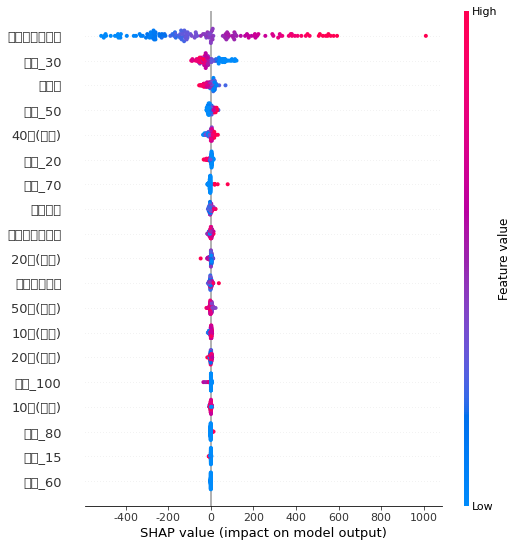

In [37]:
shap.summary_plot(shap_values, X_test,feature_names)

# 모든 변수들의 shap value를 요약한 것으로 해당 변수가 빨간색을 띄면 target(price)에 대해 양의 영향력, 파란색을 띄면 음의 영향력을 가진다. 


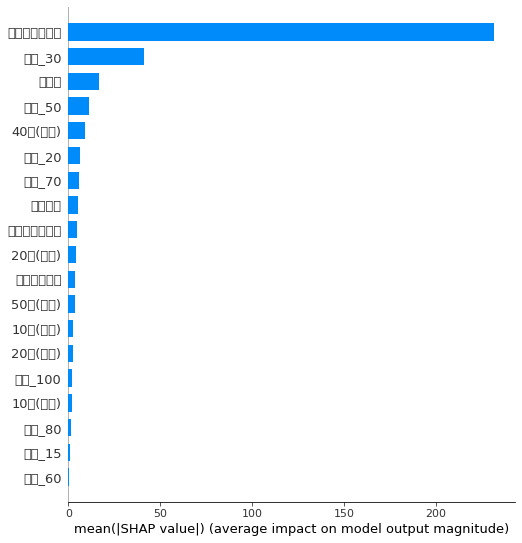

In [38]:
 # 각 변수에 대한 |Shap Values|을 통해 변수 importance 파악
shap.summary_plot(shap_values, X_test, plot_type = "bar")